# Retrieval of the TOA Reflectance from the MYD02HKM data

The SARA is based on the satellite received spectral reflectance (ρλ), which is a func- tion of measured spectral radiance (LTOA(λ)), solar zenith angle, earth–sun distance in astronomical unit and mean solar exoatmospheric radiation (Eq. 1):

$\rho_{TOA(\lambda)} = \frac{\pi L_{TOA(\lambda)}d^2}{ESUN_{\lambda}\mu_s}$

where $\rho_{TOA(\lambda)}$ = satellite received TOA spectral reflectance, $L_{TOA(\lambda)}$ = satellite received TOA spectral radiance, $ESUN_{\lambda}$ = mean solar exoatmospheric radiation radiation as a function of MODIS band number. For MODIS band 4, the $ESUN_{\lambda}$ value is 1850 (*Tasumi et al., 2008*). $μ_s$ = cosine of solar zenith angle.

Parameter $d^2$ can be calculated as a function of day of year using Duffie and Beckman 􏰀1991􏰁 (Eq. 2):

$d^2 = \frac{1}{1+0.033 \cos(DOY\cdot 2\pi /365)}$

where $DOY$ = day of year and 􏰀$DOY·2􏰘/365􏰁$ 􏰀(rad􏰁)


In [2]:
%matplotlib inline
import readData as rd
import math
import numpy as np
import matplotlib.pyplot as plt
# import pandas as pd

                   0
count  711954.000000
mean     2197.277137
std      1089.267129
min      1199.000000
25%      1360.000000
50%      1508.000000
75%      2868.000000
max      9325.000000
                   0
count  711954.000000
mean        0.068884
std         0.034148
min         0.037589
25%         0.042636
50%         0.047276
75%         0.089912
max         0.292338


## Load Data

In [3]:
MYD02HKM = rd.read_data3('MYD02HKM')
MYD03 = rd.read_data('MYD03')
# MYD02_E_LUTs = rd.read_data('MYD02_Emissive_LUTs', LUT_mode=True)
# MYD02_R_LUTs = rd.read_data('MYD02_Reflective_LUTs', LUT_mode=True)
# MYD02_Q_LUTs = rd.read_data('MYD02_QA_LUTs', LUT_mode=True)
# MYD09GA = rd.read_data('MYD09GA')

MYD02HKM/MYD02HKM.A2019299.2130.061.2019300153603.psgscs_000501391352.hdf
MYD02HKM/MYD02HKM.A2019302.2020.061.2019303155337.psgscs_000501391352.hdf
MYD02HKM/MYD02HKM.A2019306.2135.061.2019307150842.psgscs_000501391352.hdf
MYD02HKM/MYD02HKM.A2019300.2030.061.2019301152343.psgscs_000501391352.hdf
MYD02HKM/MYD02HKM.A2019301.2115.061.2019302151923.psgscs_000501391352.hdf
MYD02HKM/MYD02HKM.A2019309.2025.061.2019310152027.psgscs_000501391352.hdf
MYD02HKM/MYD02HKM.A2019302.2200.061.2019303153950.psgscs_000501391352.hdf
MYD02HKM/MYD02HKM.A2019303.2105.061.2019304153027.psgscs_000501391352.hdf
MYD02HKM/MYD02HKM.A2019298.2045.061.2019299151631.psgscs_000501391352.hdf
MYD02HKM/MYD02HKM.A2019307.2040.061.2019308152443.psgscs_000501391352.hdf
MYD02HKM/MYD02HKM.A2019304.2145.061.2019305151204.psgscs_000501391352.hdf
MYD02HKM/MYD02HKM.A2019304.2010.061.2019305151339.psgscs_000501391352.hdf
MYD02HKM/MYD02HKM.A2019299.2125.061.2019300153403.psgscs_000501391352.hdf
MYD02HKM/MYD02HKM.A2019303.2100.061.20

In [4]:
# print('--- MYD02 Reflective LUTs ---')
# for item in MYD02_R_LUTs[0]['dataset_list']:
#     print(item[1])

According to the LUT provided by the MODIS Characterization Support Team (MCST), the data in scaled integer bands should be converted. 

For MODIS band 4, the values of the DN are scaled from \[0, 4095\] to \[0, 32767]. In this regard, we need to covert the data back to its correct values. 

In [5]:
# data02 = rd.openSubDataset(MYD02HKM[0]['dataset_list'], 4)
# corrected_counts_scale = 4095 / 32767
# corrected_counts_offset = - ( 32767 * 0 ) / ( 4095 )
# data02 = data02 / 32767 * 4095
data02 = MYD02HKM[0]['data']
lon = MYD02HKM[0]['lon']
lat = MYD02HKM[0]['lat']
year = MYD02HKM[0]['year']
dofy = MYD02HKM[0]['dofy']
hour = MYD02HKM[0]['hour']
minute = MYD02HKM[0]['minute']

data03meta = rd.search_data(MYD03, year, dofy, hour, minute)
sensorZenith = rd.openSubDataset(data03meta[0]['dataset_list'], 3)
sensorZenith = rd.resample_integral_multiple(sensorZenith, 2)
sensorAzimuth = rd.openSubDataset(data03meta[0]['dataset_list'], 4)
sensorAzimuth = rd.resample_integral_multiple(sensorAzimuth, 2)
solarZenith = rd.openSubDataset(data03meta[0]['dataset_list'], 6)
solarZenith = rd.resample_integral_multiple(solarZenith, 2)
solarAzimuth = rd.openSubDataset(data03meta[0]['dataset_list'], 7)
solarAzimuth = rd.resample_integral_multiple(solarAzimuth, 2)

# Convert the angles to radians.
sensorZenith = rd.to_radian(sensorZenith)
sensorAzimuth = rd.to_radian(sensorAzimuth)
solarZenith = rd.to_radian(solarZenith)
solarAzimuth = rd.to_radian(solarAzimuth)


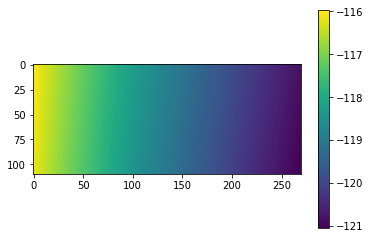

In [6]:
# lat = rd.openSubDataset(MYD02HKM[0]['dataset_list'], 2)
# lon = rd.openSubDataset(MYD02HKM[0]['dataset_list'], 3)

plt.imshow(lon)
plt.colorbar()

## Data Exploration

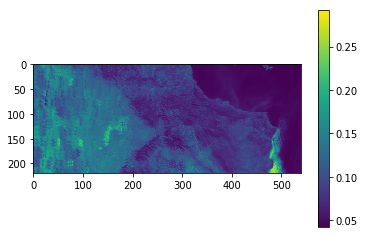

In [7]:
plt.imshow(data02)
plt.colorbar()

/Users/weiye/.conda/envs/New37/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


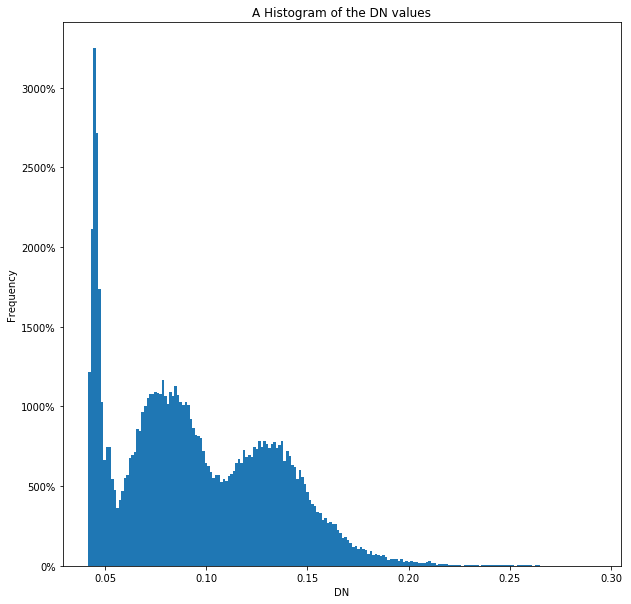

In [7]:
rd.show_histogram(data02)

In [8]:
rd.show_descriptives(data02)

                   0
count  118800.000000
mean        0.095705
std         0.038117
min         0.041601
25%         0.065772
50%         0.089692
75%         0.125995
max         0.292369


In [9]:
d2 = 2 * math.pi * dofy / 365
d2 = 0.033 * math.cos(d2) + 1
d2 = 1 / d2
print("d^2 = ", d2)
ESUN = 1850
print('ESUN = ', ESUN)
# µ_v = pd.DataFrame(np.cos(solarZenith.values / 180 * math.pi / 100))
µ_s = np.cos(solarZenith)
µ_v = np.cos(sensorZenith)

d^2 =  0.9862941325040683
ESUN =  1850


                   0
count  118800.000000
mean        0.000275
std         0.000113
min         0.000115
25%         0.000187
50%         0.000255
75%         0.000366
max         0.000823


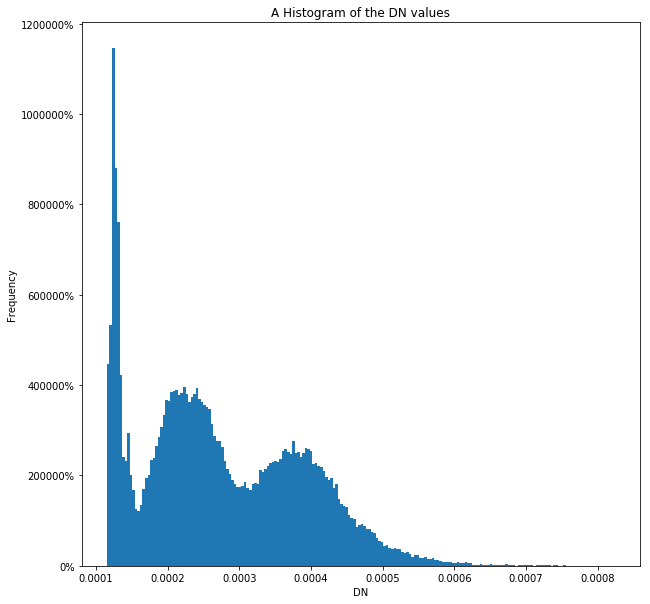

In [10]:
rho_TOA = math.pi * data02 * d2 / (ESUN * µ_s)
rd.show_histogram(rho_TOA)
rd.show_descriptives(rho_TOA)

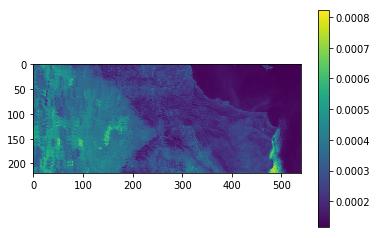

In [11]:
plt.imshow(rho_TOA)
plt.colorbar()

# Rayleigh Reflectance

### **Calculating the scattering Angle**

According to [Levy et. al](https://doi.org/10.1029/2006JD007811), the scattering angle could be calculated from the following function:

$\Theta = \cos^{-1} (-\cos \theta_0\cos\theta + \sin \theta_0 \sin \theta \cos \phi)$

where $θ_0$, $θ$, and $ϕ$ are the **solar zenith**, **sensor view zenith**, and **relative azimuth angles**, respectively. 
Relative azimuth could be computed by using this function:

$\phi = sensor_{az} - solar_{az} - 180$
http://oceancolor.gsfc.nasa.gov/forum/oceancolor/topic_show.pl?pid=12697;hl=scattering%20angle#pid12697

The Rayleigh reflectance could be calculated from the following equation:
> Bilal, M.; Nazeer, M.; Nichol, J.E.; Bleiweiss, M.P.; Qiu, Z.; Jäkel, E.; Campbell, J.R.; Atique, L.; Huang, X.; Lolli, S. A Simplified and Robust Surface Reflectance Estimation Method (SREM) for Use over Diverse Land Surfaces Using Multi-Sensor Data. Remote Sens. 2019, 11, 1344.

$\rho_R = P_R \cdot \frac{1 - e^{-M\tau_r}}{4(\mu_s + \mu_v)}$

where M = air mass = $\frac1{\mu_s}+ \frac1{\mu_v}$, 

$\tau_r$ = Rayleigh optical depth = $0.008569\lambda^{-4}(1 + 0.0113\lambda^{-2} + 0.0013\lambda^{-4})$, $\lambda$ is in radian; 

$P_R$ is the Rayleigh phase function = $\frac{3A}{4+B}(1 + \cos^2\Theta)$;

A and B are coefficients that account for the molecular asymmetry: $A = 0.9587256,\ B = 1−A$



                   0
count  118800.000000
mean        0.033600
std         0.004665
min         0.028274
25%         0.029538
50%         0.032152
75%         0.036880
max         0.045318


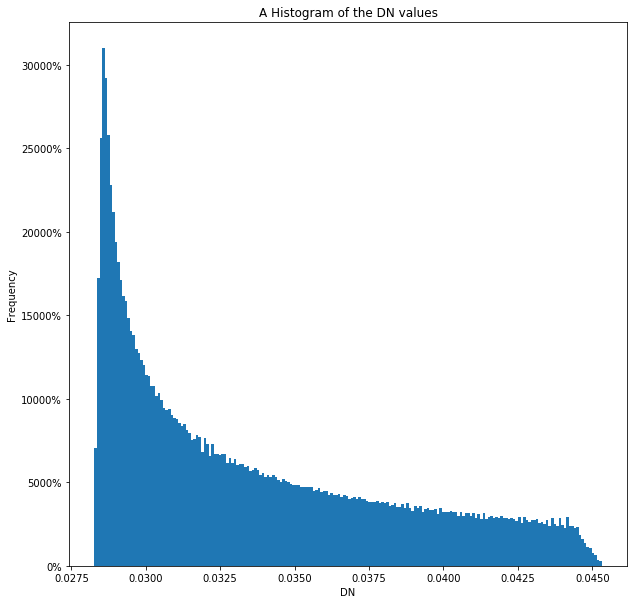

In [12]:
phi = sensorZenith - solarAzimuth - math.pi
cos_phi = np.cos(phi)
cos_Theta = -np.cos(solarZenith) * np.cos(sensorZenith) + np.sin(solarZenith) * np.sin(sensorZenith) * cos_phi
P_R = 3 * 0.9587256 / (5 - 0.9587256) * (1 + cos_Theta * cos_Theta)
wavelen = 0.555
tau_r = 0.008569 * math.pow(wavelen, -4) * (1 + 0.0113 * math.pow(wavelen, -2) + 0.0013 * math.pow(wavelen, -4))
M = 1/µ_v + 1/µ_s
rho_Ray = P_R * (1 - np.power(math.e, - M * tau_r)) / (4 * (µ_s + µ_v))

rd.show_descriptives(rho_Ray)
rd.show_histogram(rho_Ray)

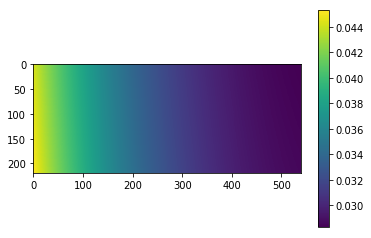

In [13]:
plt.imshow(rho_Ray)
plt.colorbar()

In [14]:
GCPs = rd.generateGCPs(lat, lon)
rd.matrix_to_geo_tiff('what.tif', rho_TOA, GCP=GCPs)


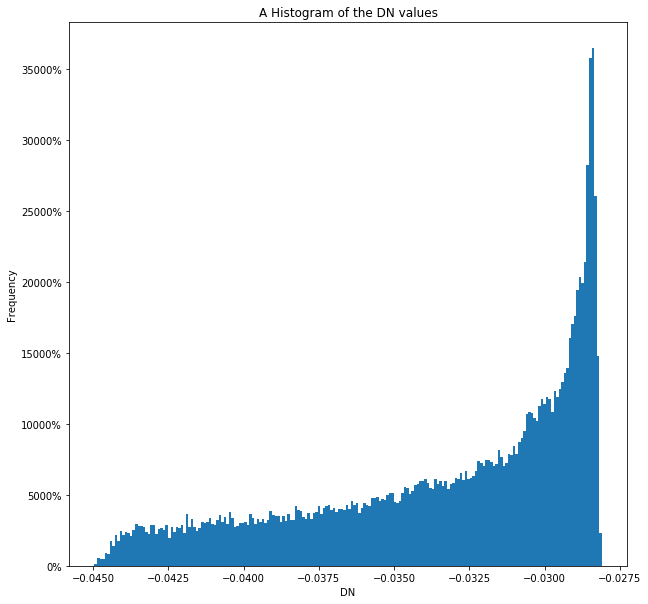

In [15]:
rd.show_histogram(rho_TOA - rho_Ray)
